In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences
from itertools import chain
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

Using TensorFlow backend.


In [3]:
from kaggle.competitions import twosigmanews

env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()

Loading the data... This could take a minute.
Done!


In [5]:
market_train = market_train_df.copy()
news_train = news_train_df.copy()

import datetime
market_train['time'] = market_train['time'].dt.date
market_train = market_train[market_train['time']>=datetime.date(2009, 1, 1)]
news_train['time'] = news_train['time'].dt.date
news_train = news_train[news_train['time']>=datetime.date(2009, 1, 1)]

In [44]:
print(market_train.shape)
print(news_train.shape)

(3340144, 16)
(7807556, 35)


In [6]:
tesla_news_15 = news_train[(news_train['assetName']=='Tesla Inc')&(news_train['time']>=datetime.date(2015, 1, 1))&(news_train['time']<=datetime.date(2016, 12, 31))]
tesla_market_15 = market_train[(market_train['assetName']=='Tesla Inc')&(market_train['time']>=datetime.date(2015, 1, 1))&(market_train['time']<=datetime.date(2016, 12, 31))]

print(tesla_news_15.shape)
print(tesla_market_15.shape)

(4122, 35)
(504, 16)


In [12]:
tesla_neg_15 = tesla_news_15[tesla_news_15['sentimentClass']==-1]
print(tesla_neg_15.shape)
tesla_neg_15_count = tesla_neg_15.groupby(['time']).size().to_frame().reset_index()
tesla_neg_15_count.columns = ['time','neg_news_count']
tesla_neg_15_count.head()

,time,neg_news_count
0,2015-01-05,2
1,2015-01-09,2
2,2015-01-13,8
3,2015-01-14,21
4,2015-01-15,3


In [13]:
tesla_pos_15 = tesla_news_15[tesla_news_15['sentimentClass']==1]
print(tesla_pos_15.shape)
tesla_pos_15_count = tesla_pos_15.groupby(['time']).size().to_frame().reset_index()

tesla_pos_15_count.columns = ['time','pos_news_count']
tesla_pos_15_count.head()

,time,pos_news_count
0,2015-01-10,2
1,2015-01-12,3
2,2015-01-13,1
3,2015-01-14,8
4,2015-01-19,3


Text(0.5,0,'Time')

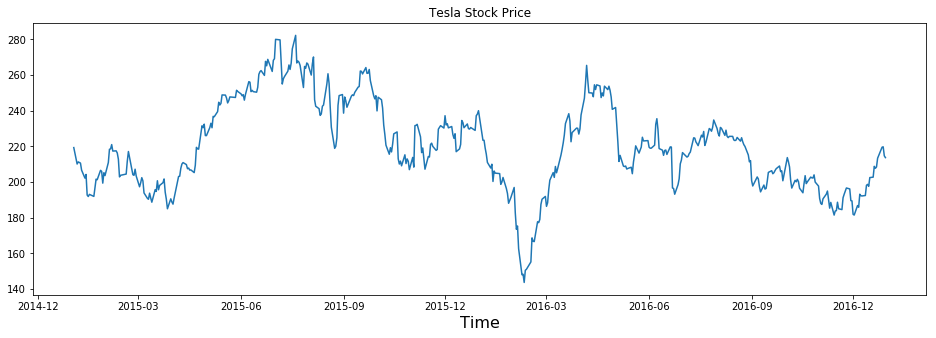

In [15]:
plt.figure(figsize=(16,5))
plt.plot(tesla_market_15['time'], tesla_market_15['close'])
plt.title('Tesla Stock Price')
plt.xlabel('Time', fontsize=16)

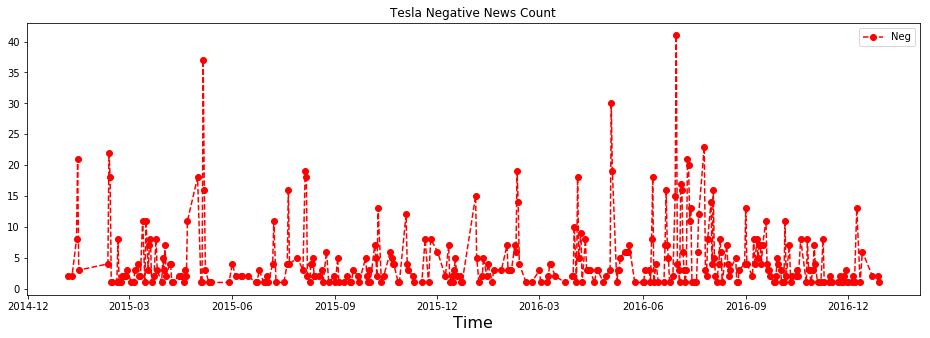

In [16]:
plt.figure(figsize=(16,5))
plt.plot(tesla_neg_15_count['time'], tesla_neg_15_count['neg_news_count'], '--ro', label='Neg')
plt.title('Tesla Negative News Count')
plt.xlabel('Time', fontsize=16)
plt.legend()

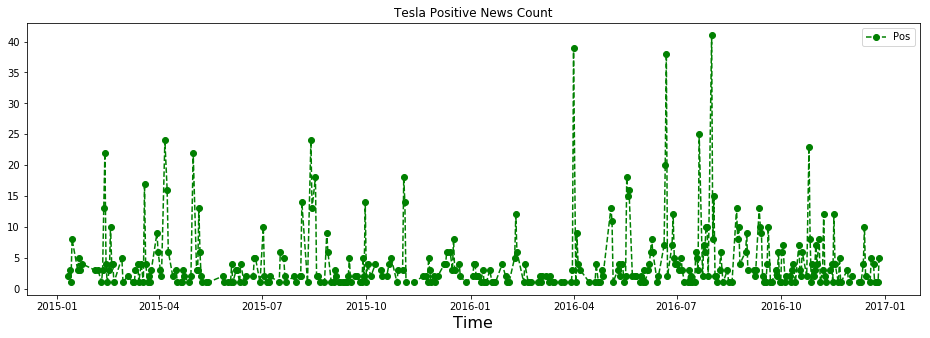

In [17]:
plt.figure(figsize=(16,5))
plt.plot(tesla_pos_15_count['time'], tesla_pos_15_count['pos_news_count'], '--go', label='Pos')
plt.title('Tesla Positive News Count')
plt.xlabel('Time', fontsize=16)
#plt.plot(tesla_news['time'], tesla_news['sentimentNeutral'], '--bo', label='Neu')
plt.legend()

In [18]:
tesla_news_09 = news_train[(news_train['assetName']=='Tesla Inc')&(news_train['time']>=datetime.date(2009, 1, 1))&(news_train['time']<=datetime.date(2016, 12, 31))]
tesla_market_09 = market_train[(market_train['assetName']=='Tesla Inc')&(market_train['time']>=datetime.date(2009, 1, 1))&(market_train['time']<=datetime.date(2016, 12, 31))]

tesla_neg_09 = tesla_news_09[tesla_news_09['sentimentClass']==-1]
print(tesla_neg_09.shape)
tesla_neg_09_count = tesla_neg_09.groupby(['time']).size().to_frame().reset_index()
tesla_neg_09_count.columns = ['time','neg_news_count']
tesla_neg_09_count.head()

tesla_pos_09 = tesla_news_09[tesla_news_09['sentimentClass']==1]
print(tesla_pos_09.shape)
tesla_pos_09_count = tesla_pos_09.groupby(['time']).size().to_frame().reset_index()
tesla_pos_09_count.columns = ['time','pos_news_count']
tesla_pos_09_count.head()

(2911, 35)
(3061, 35)


,time,pos_news_count
0,2010-06-29,9
1,2010-06-30,3
2,2010-07-06,1
3,2010-07-08,2
4,2010-07-09,2


Text(0.5,0,'Time')

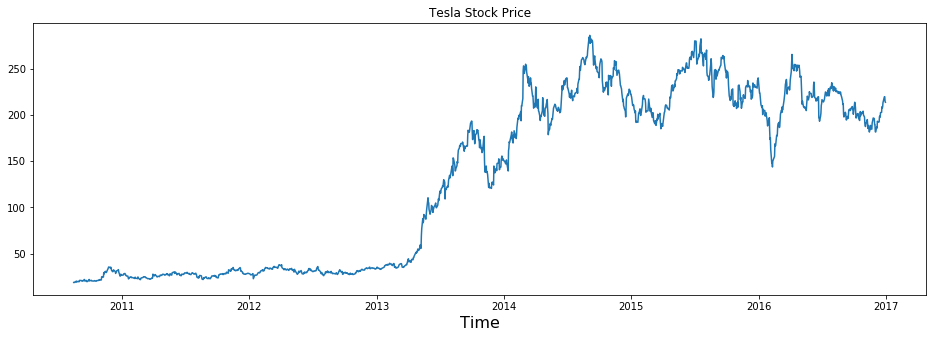

In [19]:
plt.figure(figsize=(16,5))
plt.plot(tesla_market_09['time'], tesla_market_09['close'])
plt.title('Tesla Stock Price')
plt.xlabel('Time', fontsize=16)


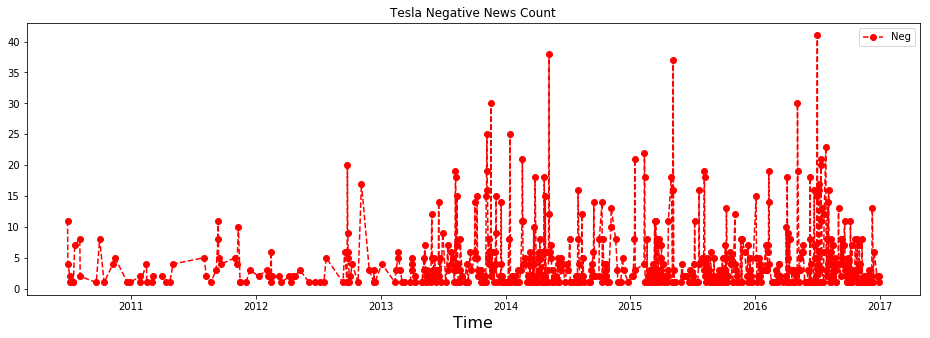

In [20]:
plt.figure(figsize=(16,5))
plt.plot(tesla_neg_09_count['time'], tesla_neg_09_count['neg_news_count'], '--ro', label='Neg')
plt.title('Tesla Negative News Count')
plt.xlabel('Time', fontsize=16)
plt.legend()

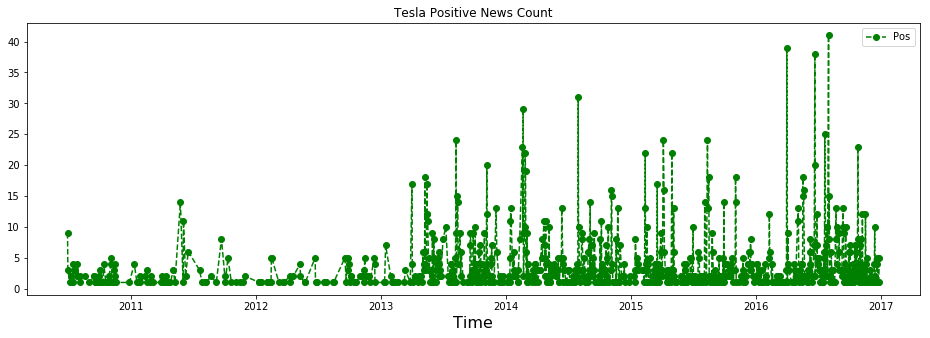

In [21]:
plt.figure(figsize=(16,5))
plt.plot(tesla_pos_09_count['time'], tesla_pos_09_count['pos_news_count'], '--go', label='Pos')
plt.title('Tesla Positive News Count')
plt.xlabel('Time', fontsize=16)
#plt.plot(tesla_news['time'], tesla_news['sentimentNeutral'], '--bo', label='Neu')
plt.legend()

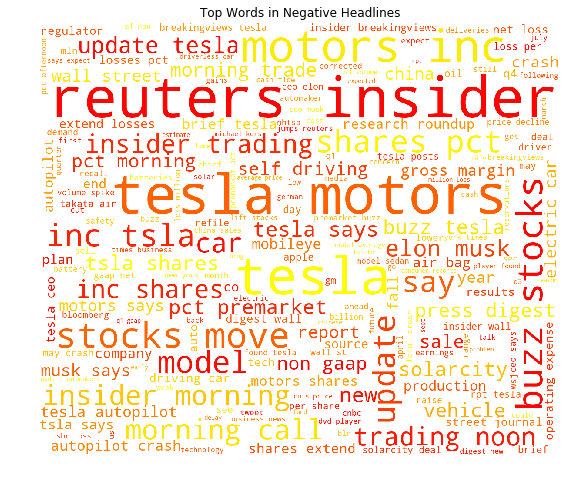

In [29]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.util import ngrams
stop = set(stopwords.words('english'))

tesla_neg_headline = ' '.join(tesla_neg_15['headline'].str.lower().values)
tesla_neg_wc = WordCloud(max_font_size=None, stopwords=stop, colormap = 'autumn', background_color='white',
                      width=1200, height=1000).generate(tesla_neg_headline)
plt.figure(figsize=(12, 8))
plt.imshow(tesla_neg_wc)
plt.title('Top Words in Negative Headlines')
plt.axis("off")
plt.show()

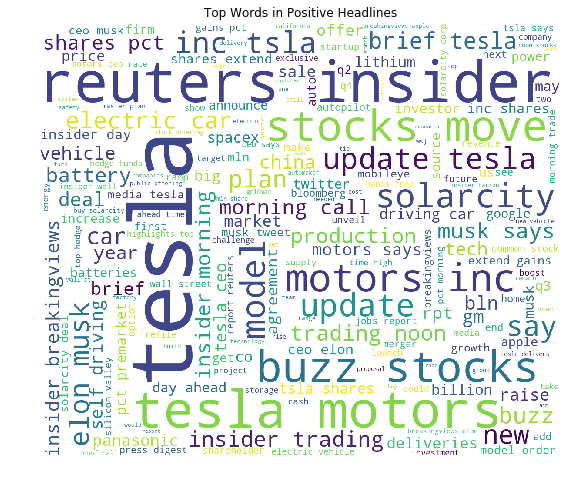

In [30]:
tesla_pos_headline = ' '.join(tesla_pos_15['headline'].str.lower().values)
tesla_pos_wc = WordCloud(max_font_size=None, stopwords=stop, colormap = 'viridis', background_color='white',
                      width=1200, height=1000).generate(tesla_pos_headline)
plt.figure(figsize=(12, 8))
plt.imshow(tesla_pos_wc)
plt.title('Top Words in Positive Headlines')
plt.axis("off")
plt.show()

In [32]:
news_16 = news_train[(news_train['time']>=datetime.date(2016, 1, 1))&(news_train['time']<=datetime.date(2016, 12, 31))]
print(news_16.shape)

(952396, 35)


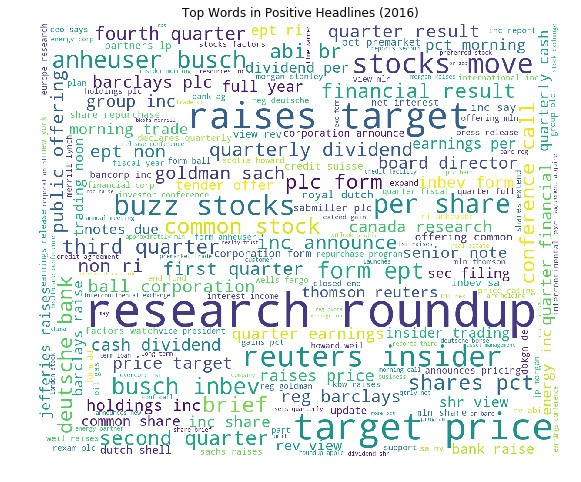

In [33]:
pos_16 = news_16[news_16['sentimentClass']==1]
pos_headline_16 = ' '.join(pos_16['headline'].str.lower().values)
pos_wc = WordCloud(max_font_size=None, stopwords=stop, colormap = 'viridis', background_color='white',
                      width=1200, height=1000).generate(pos_headline_16)
plt.figure(figsize=(12, 8))
plt.imshow(pos_wc)
plt.title('Top Words in Positive Headlines (2016)')
plt.axis("off")
plt.show()

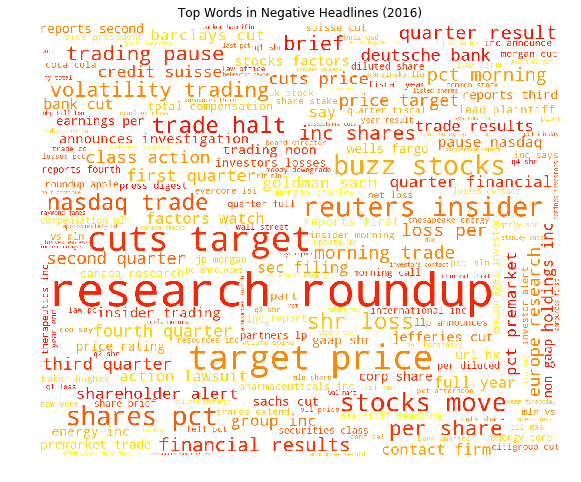

In [34]:
neg_16 = news_16[news_16['sentimentClass']==-1]
neg_headline_16 = ' '.join(neg_16['headline'].str.lower().values)
neg_wc = WordCloud(max_font_size=None, stopwords=stop, colormap = 'autumn', background_color='white',
                      width=1200, height=1000).generate(neg_headline_16)
plt.figure(figsize=(12, 8))
plt.imshow(neg_wc)
plt.title('Top Words in Negative Headlines (2016)')
plt.axis("off")
plt.show()

In [41]:
#top sources
news_train['provider'].value_counts().head(10)/news_train.shape[0]

RTRS    0.790341
PRN     0.071063
BSW     0.067540
GNW     0.019639
MKW     0.018512
LSE     0.008229
HIIS    0.007491
RNS     0.006437
CNW     0.004549
ONE     0.003232
Name: provider, dtype: float64

In [40]:
news_train['urgency'].value_counts()/news_train.shape[0]

3    0.643426
1    0.356571
2    0.000003
Name: urgency, dtype: float64

In [39]:
news_train['sentimentClass'].value_counts()/news_train.shape[0]

 1    0.392524
 0    0.305358
-1    0.302118
Name: sentimentClass, dtype: float64

In [43]:
news_train['headlineTag'].value_counts()[:10]

                         5311174
BRIEF                     492579
U.S. RESEARCH ROUNDUP     286698
UPDATE 1                  266789
UPDATE 2                  146945
BUZZ                      135950
RPT                       123347
MARKET PULSE              104225
US RESEARCH SUMMARY        77159
UPDATE 3                   74419
Name: headlineTag, dtype: int64

In [49]:
# exclude outliers
# 3-sigma rule: in normal distribution, 99% of datapoints are within 3 std away from mean
num_cols = [col for col in market_train.columns if col not in ['time', 'assetCode', 'assetName']]
for col in num_cols:
    market_train = market_train[np.abs(market_train[col]-market_train[col].mean()) <= 3*market_train[col].std()]
print(market_train.shape)

(2811258, 16)


Text(0.5,0,'Price (USD)')

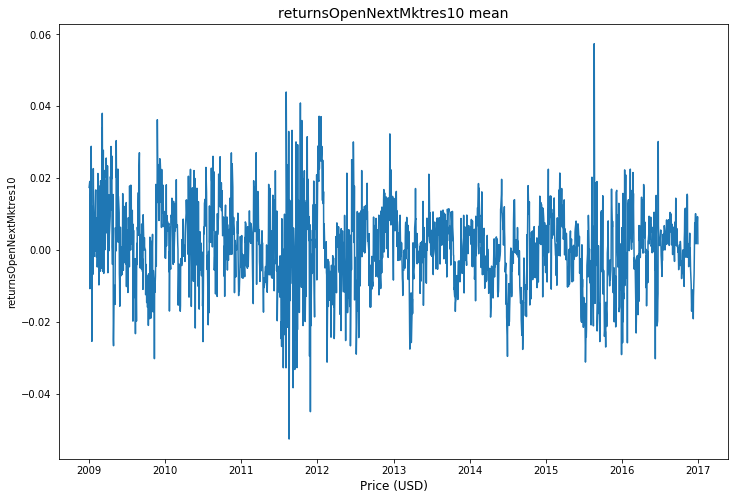

In [51]:
plt.figure(figsize=(12,8))
price_df = market_train.groupby('time')['returnsOpenNextMktres10'].mean().to_frame().reset_index()
sns.lineplot(x=price_df['time'], y=price_df['returnsOpenNextMktres10'])
plt.title('returnsOpenNextMktres10 mean', fontsize=14)
plt.xlabel('Price (USD)', fontsize=12)

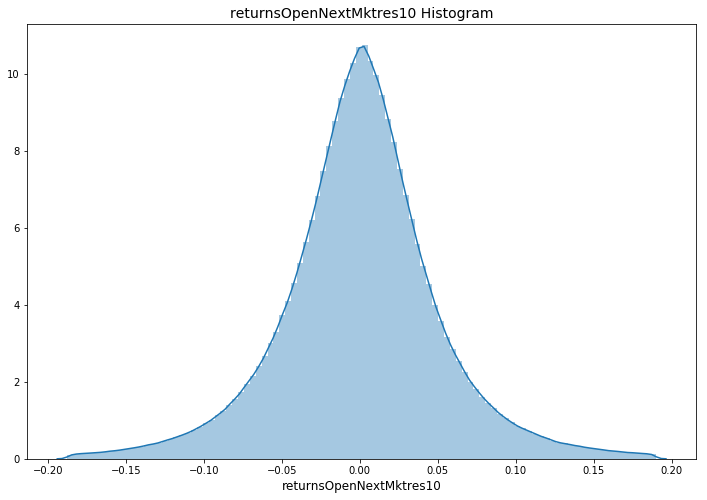

In [52]:
plt.figure(figsize=(12,8))
sns.distplot(market_train['returnsOpenNextMktres10'].values, bins=100)
plt.xlabel('returnsOpenNextMktres10', fontsize=12)
plt.title("returnsOpenNextMktres10 Histogram", fontsize=14)
plt.show()

In [57]:
print(market_train['returnsOpenNextMktres10'].min())
print(market_train['returnsOpenNextMktres10'].max())

-0.18753432424298172
0.18983862829401163


In [60]:
mean = market_train['returnsOpenNextMktres10'].mean()
sigma = market_train['returnsOpenNextMktres10'].std()
print(market_train['returnsOpenNextMktres10'].mean())
print(market_train['returnsOpenNextMktres10'].std())

0.0005972701764744222
0.05035175352998002


In [67]:
bincount = np.histogram(market_train['returnsOpenNextMktres10'].values, bins=6)
print(bincount)

(array([  42495,  216877, 1155143, 1151414,  203023,   42306]), array([-0.18753432, -0.12463883, -0.06174334,  0.00115215,  0.06404764,
        0.12694314,  0.18983863]))


In [68]:
binpercent = bincount[0]/len(market_train['returnsOpenNextMktres10'].values)
print(binpercent)

[0.01511601 0.07714589 0.41089896 0.40957251 0.07221785 0.01504878]


In [64]:
market_train['returnsOpenNextMktres10'].describe()

count    2.811258e+06
mean     5.972702e-04
std      5.035175e-02
min     -1.875343e-01
25%     -2.659354e-02
50%      8.604424e-04
75%      2.775573e-02
max      1.898386e-01
Name: returnsOpenNextMktres10, dtype: float64

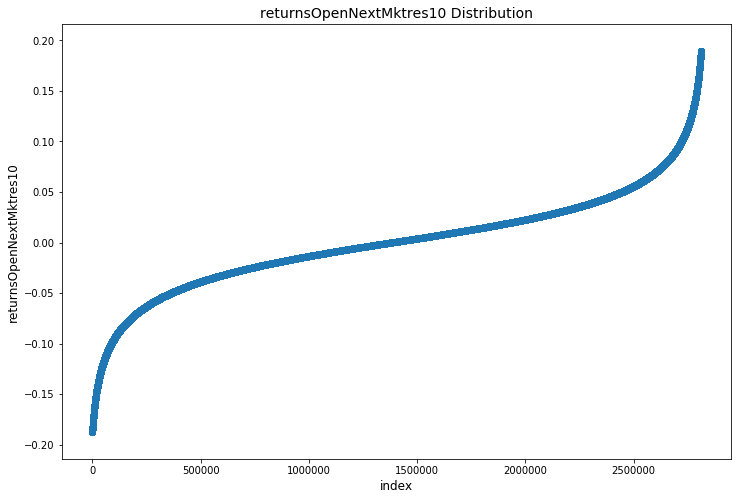

In [56]:
plt.figure(figsize=(12,8))
plt.scatter(range(market_train.shape[0]), np.sort(market_train['returnsOpenNextMktres10'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('returnsOpenNextMktres10', fontsize=12)
plt.title("returnsOpenNextMktres10 Distribution", fontsize=14)
plt.show()

In [54]:
len(market_train['returnsOpenNextMktres10'].values)

2811258

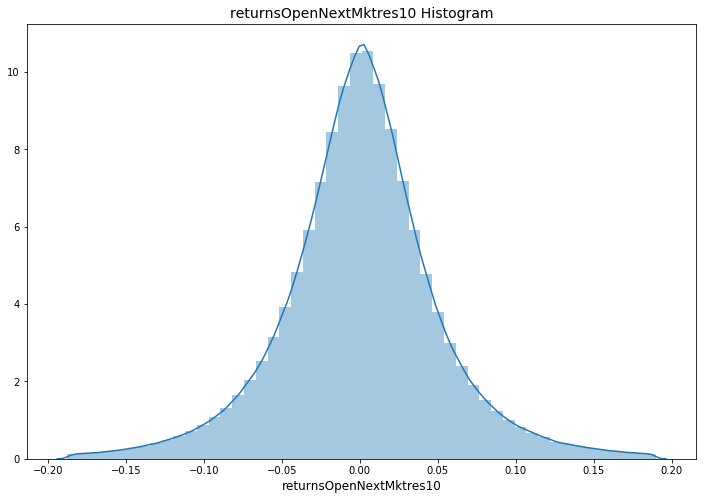

In [53]:
plt.figure(figsize=(12,8))
sns.distplot(market_train['returnsOpenNextMktres10'].values, bins=50)
plt.xlabel('returnsOpenNextMktres10', fontsize=12)
plt.title("returnsOpenNextMktres10 Histogram", fontsize=14)
plt.show()